# Plot bottom temperature anomonalies for WIND+, WIND-, WIND+zonal, WIND+meridional

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.path as mpath
import cosima_cookbook as cc
import cmocean.cm as cmocean
import cmocean.cm as cm
from collections import OrderedDict
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44619 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
# 10% increase in easterly wind speed, meridional component only:
easterlies_up_mer = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
# 10% increase in easterly wind speed, zonal component only:
easterlies_up_zon = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'

# plot anomalies for 5 years, years 5-10 of simulation:
#start_time = '2159-01-01' 
start_time = '2155-01-01'
end_time   = '2159-12-31'

lat_slice  = slice(-80,-59)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

## Import bottom temperature

Temperature

In [11]:
temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

temp_up = cc.querying.getvar(easterlies_up, 'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
temp_up = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

temp_down = cc.querying.getvar(easterlies_down,'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
temp_down = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')  

temp_up_mer = cc.querying.getvar(easterlies_up_mer, 'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
temp_up_mer = temp_up_mer.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time') 

temp_up_zon = cc.querying.getvar(easterlies_up_zon, 'temp', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
temp_up_zon = temp_up_zon.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')  

In [12]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth   = depth_array.max(dim = 'st_ocean', skipna= True)

In [13]:
bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

In [14]:
bottom_temp_up = temp_up.where(depth_array.st_ocean >= max_depth)
bottom_temp_up = bottom_temp_up.sum(dim = 'st_ocean')
bottom_temp_up = bottom_temp_up.load()

In [15]:
bottom_temp_down = temp_down.where(depth_array.st_ocean >= max_depth)
bottom_temp_down = bottom_temp_down.sum(dim = 'st_ocean')
bottom_temp_down = bottom_temp_down.load()

In [ ]:
bottom_temp_up_mer = temp_up_mer.where(depth_array.st_ocean >= max_depth)
bottom_temp_up_mer = bottom_temp_up_mer.sum(dim = 'st_ocean')
bottom_temp_up_mer = bottom_temp_up_mer.load()

In [ ]:
bottom_temp_up_zon = temp_up_zon.where(depth_array.st_ocean >= max_depth)
bottom_temp_up_zon = bottom_temp_up_zon.sum(dim = 'st_ocean')
bottom_temp_up_zon = bottom_temp_up_zon.load()

## Plotting

In [5]:
# Figure path
fig_path = '/g/data/x77/wgh581/Figures/Easterlies-Collab/'
# Panel labels
panel_name = ['a)', 'b)', 'c)', 'd)']
# Font size
plt.rcParams['font.size'] = 18
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

Isobath

In [6]:
contour_data  = np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
contour_mask_numbered = contour_data['contour_mask_numbered']
contour_1000m = np.where(contour_mask_numbered == 0, contour_mask_numbered, 1000)
contour_xt_ocean = contour_data['xt_ocean']
contour_yt_ocean = contour_data['yt_ocean']

Bottom temp anomaly, WIND+, WIND-, WIND+merid, WIND+zonal

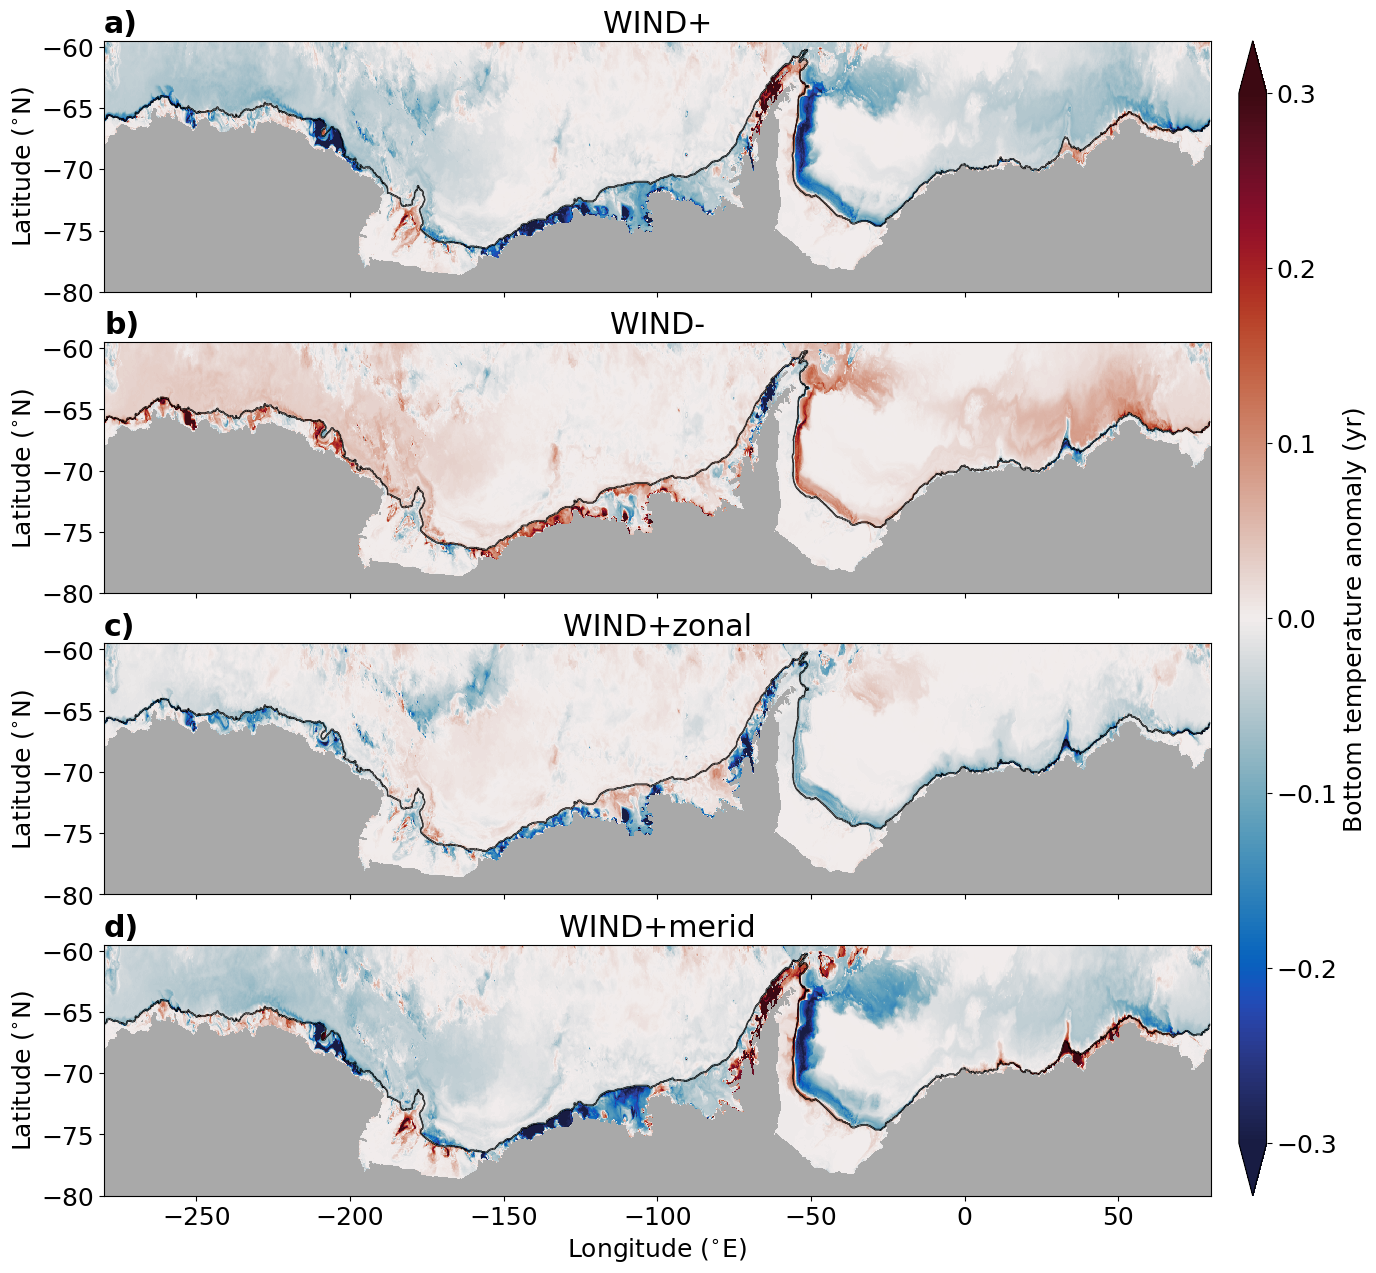

In [26]:
fig = plt.figure(figsize=(15, 15))
# Panel title
title_name = ['WIND+', 'WIND+$_zonal$', 'WIND+$_merid$', 'WIND-']
# Subplots grid
gs  = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 0.025], wspace=0.05)

# Define subplot, add panel title and label
def plot_land():
    ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
    ax.set_xlim([-280, 80])
    ax.set_ylim([-80, -59.5])
    # Add land 
    ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    ax.contour(contour_xt_ocean, contour_yt_ocean, contour_1000m, [1000],colors='k', linewidths=0.5)

for ii in range(4):
    if ii == 0:
        # Temp, WIND+
        ax = fig.add_subplot(gs[ii])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, (bottom_temp_up-bottom_temp_con), cmap=cmocean.balance, vmin=-0.3, vmax=0.3) 
    elif ii == 1:
        # Temp, WIND+meridional
        ax = fig.add_subplot(gs[ii+1])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, (bottom_temp_up_mer-bottom_temp_con), cmap=cmocean.balance, vmin=-0.3, vmax=0.3) 
    elif ii == 2:
        # Temp, WIND+zonal
        ax = fig.add_subplot(gs[ii+2])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, (bottom_temp_up_zon-bottom_temp_con), cmap=cmocean.balance, vmin=-0.3, vmax=0.3) 
    elif ii == 3:
        # Temp, WIND-
        ax = fig.add_subplot(gs[ii+3])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, (bottom_temp_down-bottom_temp_con), cmap=cmocean.balance, vmin=-0.3, vmax=0.3) 
        plt.xlabel('Longitude ($^{\circ}$E)')
    plt.ylabel('Latitude ($^{\circ}$N)')
    if ii < 3:
        plt.tick_params(labelbottom=False)
        
        
# Add colorbar
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = plt.colorbar(cf, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Bottom temperature anomaly (yr)')

# Finished
save_fig = 0
if save_fig == 1:
    fig_name = 'Figure10.png'#'Fig9_Temp_anomaly.png'
    plt.savefig(fig_path + fig_name)